In [25]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
import torch

from files.training import generate_data, generate_data_elliptic

from Base.lla import dgala
from Base.utilities import clear_hooks

# Laplace Approx Burgers Eq

In [27]:
dnn = True
path_models= f"./models/{'dnn_models/' if dnn else ''}Burgers_MDNN_s{{bs}}.pth"
path_dgala =  f"./models/dnn_models/burgers_lla_s{{bs}}.pth"
last_layer_name = 'layers.output_layer'  if dnn else 'output_layer'

In [3]:
batch_size = [100,1500]

for i,bs in enumerate(batch_size):
    data_int,ini_c, left_bc, right_bc = generate_data(size=bs, nparam = 1, seed = 10, burgers=True)

    data_trainig = {"data_fit": {"pde":data_int, "ic_loss":ini_c,"bc_loss":(left_bc, right_bc)}, 
                    "class_method": {"pde": ["burgers_pde"], "ic_loss":["u"], "bc_loss":["u","u"]},
                    "outputs": {"pde": ["burgers"], "ic_loss": ["uic"],"bc_loss":["ubcl","ubcr"]}}

    burgers_model = torch.load(path_models.format(bs=bs))
    burgers_model.eval()
    llp = dgala(burgers_model,last_layer_name=last_layer_name)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, path_dgala.format(bs=bs))

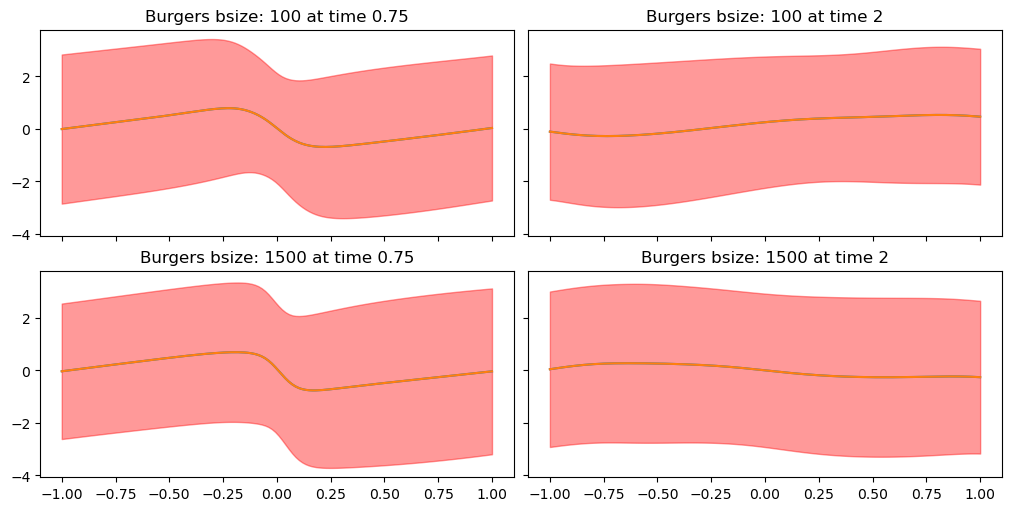

In [4]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(-1, 1, 128)  # Spatial grid in X direction

param_ =  (0.01/np.pi)
batch_size = [100,1500]

for i,bs in enumerate(batch_size):
    
    burgers_model = torch.load(path_models.format(bs=bs))
    burgers_model.eval()

    llp = torch.load(path_dgala.format(bs=bs))
    llp.model.set_last_layer(last_layer_name)  # Re-register hooks

    for j,dt in enumerate([0.75,2]):
        data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

        nn_pred = burgers_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].plot(X, surg_mu)

        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Burgers bsize: {bs} at time {dt}")

In [28]:
llp = torch.load(path_dgala.format(bs=100))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

llp.optimize_marginal_likelihood(max_iter=1000,error_tolerance=1e-9)
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00826, neg_marglik: -9.96685
Iteration 200, Error: 0.00595, neg_marglik: -291.87903
Iteration 300, Error: 0.00225, neg_marglik: -348.47354
Iteration 400, Error: 0.00124, neg_marglik: -348.83640
Iteration 500, Error: 0.00090, neg_marglik: -348.85114
Iteration 600, Error: 0.00063, neg_marglik: -348.85776
Iteration 700, Error: 0.00042, neg_marglik: -348.86057
Iteration 800, Error: 0.00027, neg_marglik: -348.86169
Iteration 900, Error: 0.00016, neg_marglik: -348.86200
Iteration 1000, Error: 0.00009, neg_marglik: -348.86212
Maximum iterations (1000)reached, sigma : 0.1011391133069992, prior: 0.06626667082309723.
tensor(0.1011) tensor([0.0663])


Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

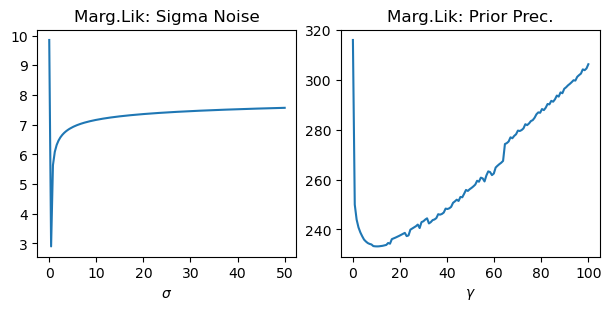

In [20]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(path_dgala.format(bs=100))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

sn = torch.linspace(0.01,50, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
#axs[0].axvline(llp.sigma_noise)
axs[0].set_xlabel(r"$\sigma$")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(path_dgala.format(bs=100))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

priorpre = torch.linspace(0.001,100, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
#axs[1].axvline(llp.prior_precision)
axs[1].set_xlabel(r"$\gamma$")
axs[1].set_title("Marg.Lik: Prior Prec.")


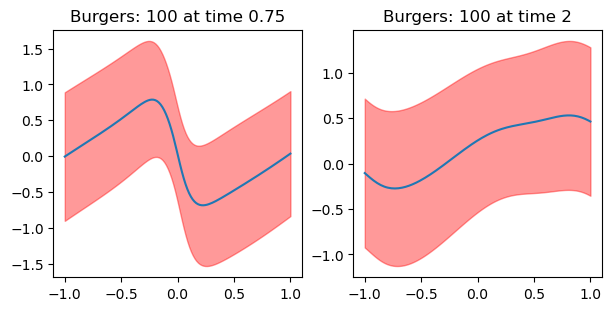

In [31]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')
X = torch.linspace(-1, 1, 128)  # Spatial grid in X direction

param_ =  (0.01/np.pi)

burgers_model = torch.load(path_models.format(bs=100))
burgers_model.eval()

# llp = torch.load(path_dgala.format(bs=100))
# llp.model.set_last_layer(last_layer_name)  # Re-register hooks

# llp.sigma_noise = 0.1674
llp.prior_precision = 10

for j,dt in enumerate([0.75,2]):
    data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

    nn_pred = burgers_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Burgers: {100} at time {dt}")

# Heat

In [32]:
dnn = True
path_models= f"./models/{'dnn_models/' if dnn else ''}Heat_MDNN_s{{bs}}.pth"
path_dgala =  f"./models/dnn_models/heat_lla_s{{bs}}.pth"
last_layer_name = 'layers.output_layer'  if dnn else 'output_layer'

In [27]:
batch_size = [1000,3000]

for i,bs in enumerate(batch_size):
    data_int,ini_c, left_bc, right_bc = generate_data(size=bs, nparam = 1, seed = 10, burgers=False)

    data_trainig = {"data_fit": {"pde":data_int, "ic_loss":ini_c,"bc_loss":(left_bc, right_bc)}, 
                    "class_method": {"pde": ["heat_pde"], "ic_loss":["u"], "bc_loss":["u","u"]},
                    "outputs": {"pde": ["heat"], "ic_loss": ["uic"],"bc_loss":["ubcl","ubcr"]}}

    heat_model = torch.load(path_models.format(bs=bs))
    heat_model.eval()

    llp = dgala(heat_model,last_layer_name=last_layer_name)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, path_dgala.format(bs=bs))

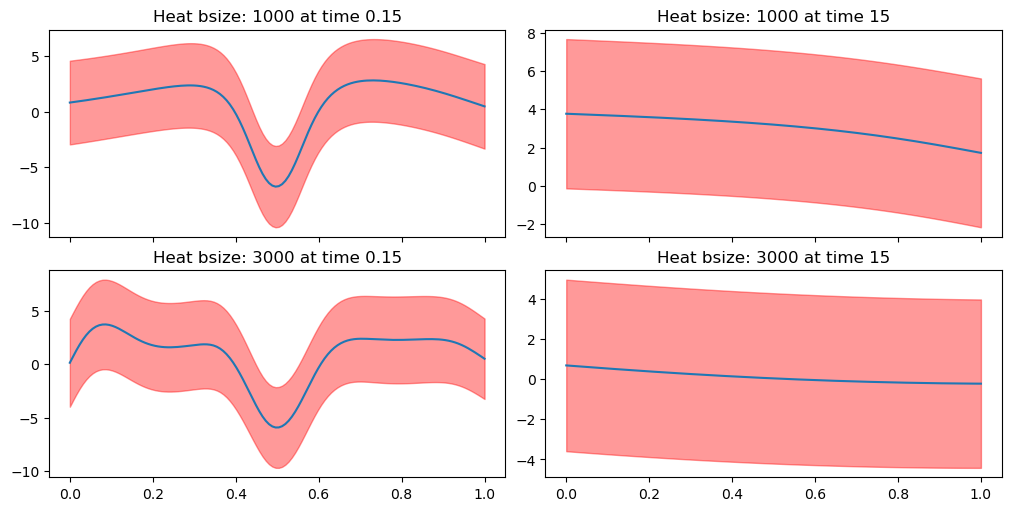

In [28]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

param_ =  0.001
batch_size = [1000,3000]

for i,bs in enumerate(batch_size):

    heat_model = torch.load(path_models.format(bs=bs))
    heat_model.eval()

    llp = torch.load(path_dgala.format(bs=bs))
    llp.model.set_last_layer(last_layer_name)  # Re-register hooks

    for j,dt in enumerate([0.15,15]):
        data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

        nn_pred = heat_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Heat bsize: {bs} at time {dt}")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

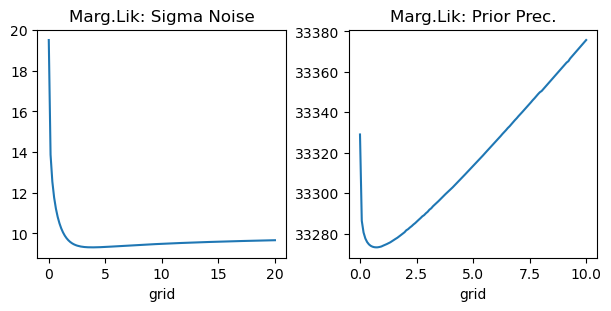

In [36]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(path_dgala.format(bs=1000))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

sn = torch.linspace(0.01,20, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
axs[0].set_xlabel("grid")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(path_dgala.format(bs=1000))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

priorpre = torch.linspace(0.001,10, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")


In [34]:
llp = torch.load(path_dgala.format(bs=1000))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

llp.optimize_marginal_likelihood()
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00558, neg_marglik: 13759.29980
Iteration 200, Error: 0.00351, neg_marglik: 11652.62988
Iteration 300, Error: 0.00248, neg_marglik: 11214.99902
Maximum iterations (300)reached, sigma : 3.234347343444824, prior: 0.15680420398712158.
tensor(3.2343) tensor([0.1568])


In [35]:
def exact_solution(x,t,theta):
    u = 4*np.sin(3*np.pi*x)*np.exp(-theta*((3*np.pi)**2)*t) + 9*np.sin(7*np.pi*x)*np.exp(-theta*((7*np.pi)**2)*t) + \
    (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)*np.exp(-theta*((5*np.pi)**2)*t) - (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)
    return u   

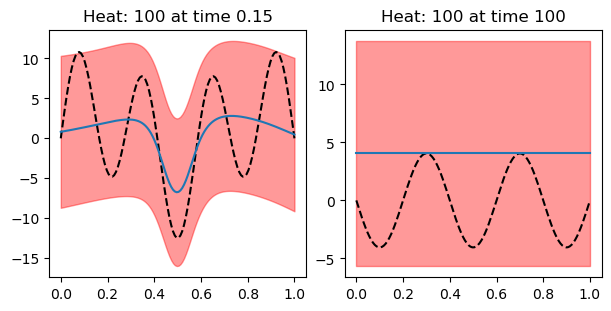

In [37]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

param_ =  0.001

heat_model = torch.load(path_models.format(bs=1000))
heat_model.eval()

# llp = torch.load(path_dgala.format(bs=1000))
# llp.model.set_last_layer(last_layer_name)  # Re-register hooks

# llp.sigma_noise = 1.9579
# llp.prior_precision = [0.1754]

for j,dt in enumerate([0.15,100]):
    data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()
    exact_sol = exact_solution(X.numpy(), dt * np.ones_like(X.numpy()),param_)

    nn_pred = heat_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X,exact_sol,linestyle = "--",color = "black", label = "Exact Solution")
    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Heat: {100} at time {dt}")

# Elliptic

In [14]:
batch_size = [150,2500]

for i,bs in enumerate(batch_size):

    data_int,left_bc,right_bc = generate_data_elliptic(size=150) 

    data_trainig = {"data_fit": {"pde":data_int, "left_bc":left_bc,"right_bc":right_bc}, 
                "class_method": {"pde": ["elliptic_pde"], "left_bc":["u"],"right_bc":["u"]},
                "outputs": {"pde": ["elliptic"], "left_bc": ["ubcl"],"right_bc":["ubcr"]}}
    
    elliptic_model = torch.load(f"./models/MDNN_s{bs}.pth")
    elliptic_model.eval()

    llp = dgala(elliptic_model)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, f"./models/elliptic_lla_s{bs}.pth")

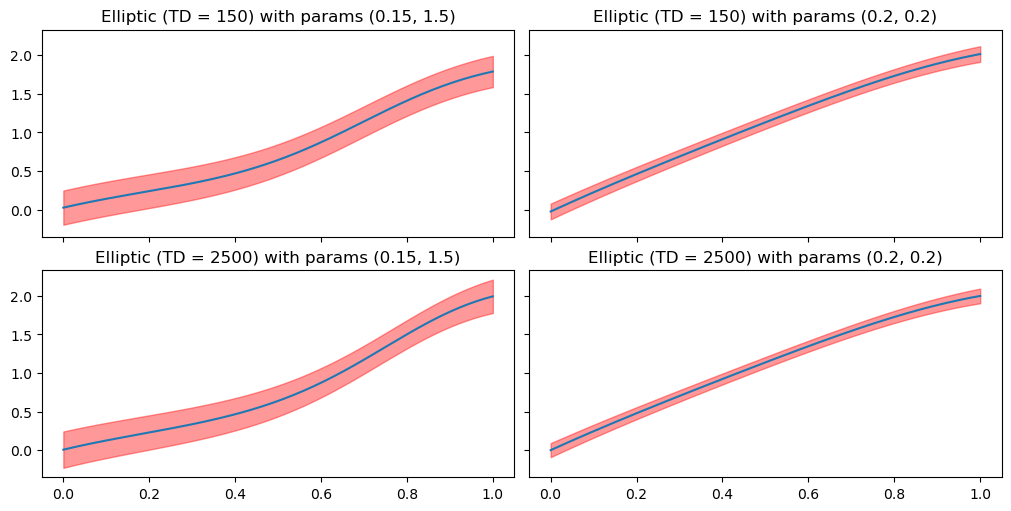

In [15]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

batch_size = [150,2500]

for i,bs in enumerate(batch_size):

    elliptic_model = torch.load(f"./models/MDNN_s{bs}.pth")
    elliptic_model.eval()

    llp = torch.load(f"./models/elliptic_lla_s{bs}.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    for j,pr in enumerate([(0.15,1.5),(.2,.2)]):

        data_test = torch.hstack((X.reshape(-1,1), torch.ones_like(X.reshape(-1,1)) * pr[0], torch.ones_like(X.reshape(-1,1)) * pr[1])).float()

        nn_pred = elliptic_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Elliptic (TD = {bs}) with params {pr}")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

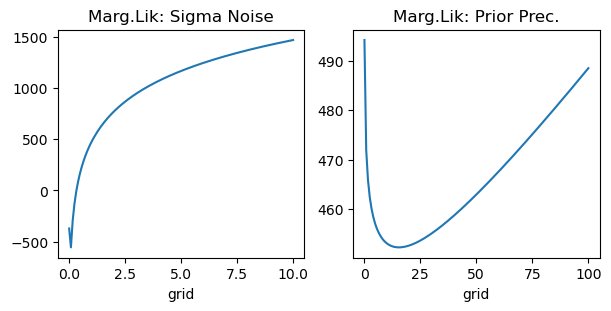

In [16]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(10, 0.01, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,log_marg_lh)
axs[0].set_xlabel("grid")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(100, 0.1, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")

In [17]:
print(llp.sigma_noise,llp.prior_precision)

tensor(1.) tensor([[0.1000]])


In [18]:
llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.optimize_marginal_likelihood(max_iter=500)
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00977, neg_marglik: 37.82542
Iteration 200, Error: 0.00882, neg_marglik: -389.97577
Iteration 300, Error: 0.00647, neg_marglik: -764.51282
Iteration 400, Error: 0.00253, neg_marglik: -941.10028
tensor(0.0241) tensor([15.8126])


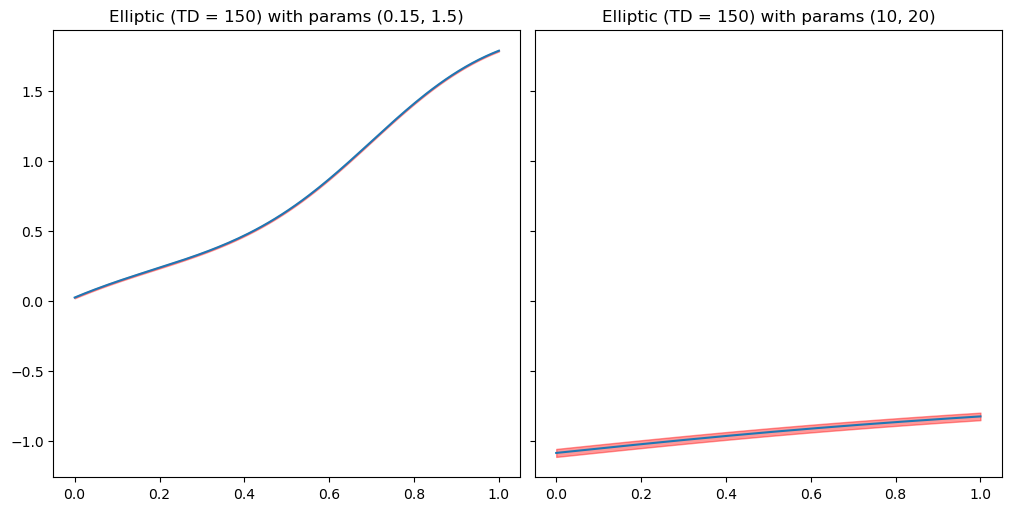

In [22]:
fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

elliptic_model = torch.load(f"./models/MDNN_s{150}.pth")
elliptic_model.eval()
bs = 150
# llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
# llp.model.set_last_layer("output_layer")  # Re-register hooks
# llp.sigma_noise = 0.0232
# llp.prior_precision = [16.2111]

for j,pr in enumerate([(0.15,1.5),(10,20)]):

    data_test = torch.hstack((X.reshape(-1,1), torch.ones_like(X.reshape(-1,1)) * pr[0], torch.ones_like(X.reshape(-1,1)) * pr[1])).float()

    nn_pred = elliptic_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Elliptic (TD = {bs}) with params {pr}")